In [28]:
from wandb_utils import get_wandb_history
from miner_performance_tracker import MinerPerformanceTracker
from reward import get_rewards, old_get_rewards
from scoring import update_scores   
from plotting import plot_metric

from tqdm import tqdm
import numpy as np
import pandas as pd
import joblib

In [2]:

start_ts = 1727846400
history_df = get_wandb_history(start_ts=start_ts)
history_df

Loaded 298 challenges from validator-193-1.1.0 (2024-10-02 08:36:14)
Loaded 294 challenges from validator-193-1.1.0 (2024-10-02 14:36:56)
Loaded 72 challenges from validator-193-1.1.0 (2024-10-02 16:07:38)
Loaded 67 challenges from validator-193-1.1.0 (2024-10-02 17:38:33)
Loaded 145 challenges from validator-193-1.1.0 (2024-10-02 20:38:16)
Loaded 21 challenges from validator-193-1.1.0 (2024-10-02 21:03:35)


In [37]:

def run_simulation(history_df, limit):
    perf_tracker = MinerPerformanceTracker()
    
    miner_sample_size = history_df['miner_uid'].apply(len).unique()[0]
    
    keys = ['old', 'new']
    scores = {k: np.zeros(256, dtype=np.float32) for k in keys}
    
    score_history = {k: [] for k in keys}
    reward_history = {k: [] for k in keys}
    
    limit = len(history_df) if limit is None else limit
    
    progress_bar = tqdm(
        history_df.iterrows(), 
        total=limit,
        desc="Computing Rewards and Scores")
    
    for i, challenge_row in progress_bar:
        if i >= limit:
            break
        
        label = challenge_row['label']
        preds = challenge_row['pred']
        uids = challenge_row['miner_uid']
        
        new_rewards = get_rewards(
            label,
            preds,
            uids,
            [1] * miner_sample_size, #challenge_row['miner_hotkeys'],
            perf_tracker)
    
        old_rewards = old_get_rewards(label, preds)
    
        scores['new'] = update_scores(scores['new'], new_rewards, uids)
        scores['old'] = update_scores(scores['old'], old_rewards, uids)
    
        reward_history['new'].append(new_rewards)
        reward_history['old'].append(old_rewards)
    
        score_history['new'].append(scores['new'])
        score_history['old'].append(scores['old'])
    
    for k in reward_history:
        diff = len(history_df) - len(reward_history[k])
        if diff != 0:
            reward_history[k] += [np.nan] * diff
        history_df['rewards_' + k] = reward_history[k]

    for k in score_history:
        diff = len(history_df) - len(score_history[k])
        if diff != 0:
            score_history[k] += [np.nan] * diff
        history_df['scores_' + k] = score_history[k]
    return history_df

In [39]:
df = run_simulation(history_df, limit=100)

Computing Rewards and Scores: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [42]:
scored_df = df[df.scores_old.notna()]

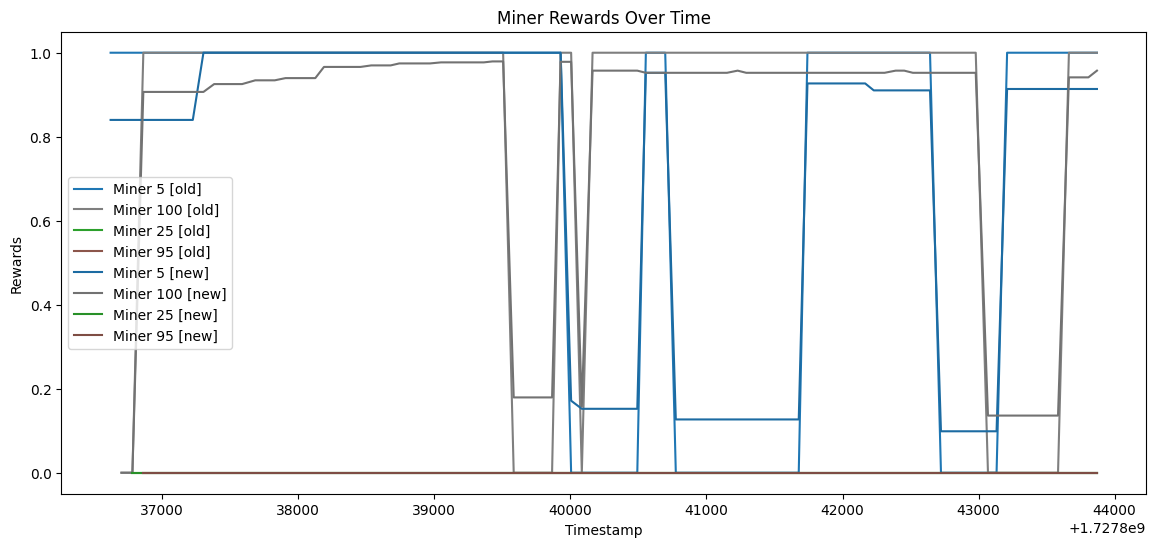

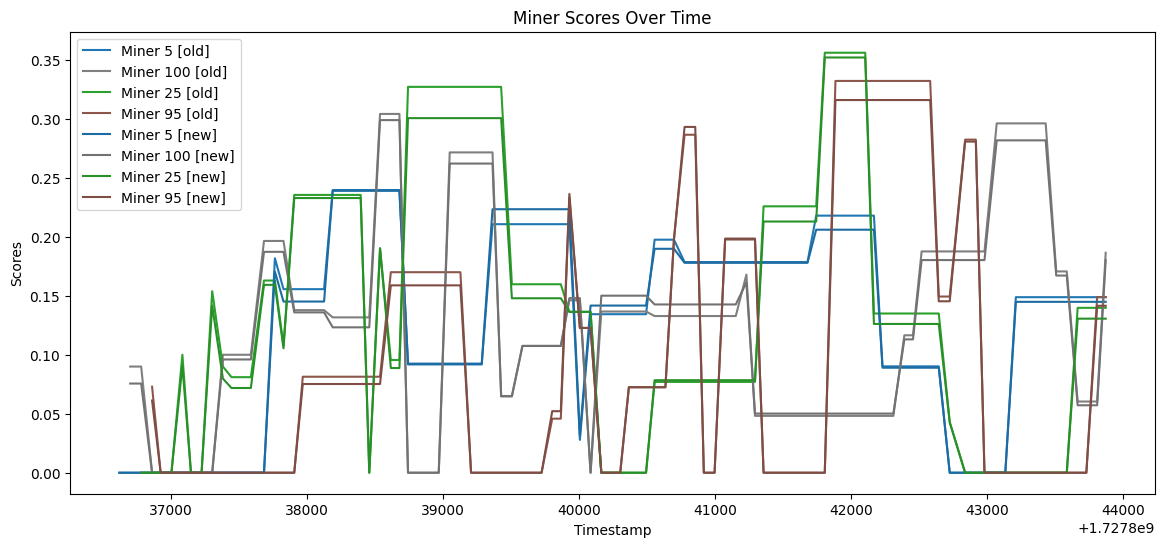

In [43]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, map_uids_to_colors=map_uids_to_colors)


In [ ]:
import math

def update_glicko_ratings(player_ids, outcomes, ratings, rd, volatility, tau=0.5):
    """
    Update Glicko ratings for multiple players based on a single round of matches.
    
    :param player_ids: List of player IDs who participated in this round
    :param outcomes: Dictionary mapping tuples of (player_id, opponent_id) to outcomes (1 for win, 0.5 for draw, 0 for loss)
    :param ratings: dict mapping player IDs to their current ratings
    :param rd: dict mapping player IDs to their current rating deviations
    :param volatility: dict mapping player IDs to their current volatilities
    :param tau: system constant, smaller values (0.3 to 1.2) are more stable
    :return: updated ratings, rating deviations, and volatilities
    """
    
    def g(RD):
        return 1 / math.sqrt(1 + 3 * (RD**2) / (math.pi**2))
    
    def E(r, r_opp, RD_opp):
        return 1 / (1 + math.exp(-g(RD_opp) * (r - r_opp) / 400))
    
    def compute_v(g_values, E_values):
        return 1 / sum((g_val**2 * E_val * (1 - E_val) for g_val, E_val in zip(g_values, E_values)))
    
    def compute_delta(v, g_values, E_values, s_values):
        return v * sum((g_val * (s_val - E_val) for g_val, E_val, s_val in zip(g_values, E_values, s_values)))
    
    def compute_new_volatility(sigma, delta, v, RD, tau):
        a = math.log(sigma**2)
        phi = RD
        epsilon = 0.000001
        
        def f(x):
            ex = math.exp(x)
            return (ex * (delta**2 - phi**2 - v - ex)) / (2 * (phi**2 + v + ex)**2) - (x - a) / (tau**2)
        
        A = a
        B = 0 if delta**2 <= phi**2 + v else math.log(delta**2 - phi**2 - v)
        
        fa = f(A)
        fb = f(B)
        
        while abs(B - A) > epsilon:
            C = A + (A - B) * fa / (fb - fa)
            fc = f(C)
            
            if fc * fb < 0:
                A = B
                fa = fb
            else:
                fa = fa / 2
            
            B = C
            fb = fc
        
        return math.exp(A / 2)
    
    def compute_new_RD(RD, sigma):
        return math.sqrt(RD**2 + sigma**2)

    new_ratings = ratings.copy()
    new_rd = rd.copy()
    new_volatility = volatility.copy()

    for player_id in player_ids:
        r = ratings[player_id]
        RD = rd[player_id]
        sigma = volatility[player_id]
        
        opponents = [opp for (p, opp), _ in outcomes.items() if p == player_id]
        s_values = [outcomes[(player_id, opp)] for opp in opponents]
        r_opps = [ratings[opp] for opp in opponents]
        RD_opps = [rd[opp] for opp in opponents]
        
        g_values = [g(RD_opp) for RD_opp in RD_opps]
        E_values = [E(r, r_opp, RD_opp) for r_opp, RD_opp in zip(r_opps, RD_opps)]
        
        v = compute_v(g_values, E_values)
        delta = compute_delta(v, g_values, E_values, s_values)
        
        new_sigma = compute_new_volatility(sigma, delta, v, RD, tau)
        new_RD = compute_new_RD(RD, new_sigma)
        new_RD = min(new_RD, 350)  # Cap RD at 350
        
        new_r = r + (new_RD**2) * sum((g_val * (s_val - E_val) for g_val, E_val, s_val in zip(g_values, E_values, s_values)))
        
        # Update the dictionaries
        new_ratings[player_id] = new_r
        new_rd[player_id] = new_RD
        new_volatility[player_id] = new_sigma
    
    return new_ratings, new_rd, new_volatility

# Example usage:
ratings = {1: 1500, 2: 1400, 3: 1550, 4: 1700}
rd = {1: 200, 2: 30, 3: 100, 4: 300}
volatility = {1: 0.06, 2: 0.06, 3: 0.06, 4: 0.06}

# Simulating a round where players 1, 2, and 3 played against each other
player_ids = [1, 2, 3]
outcomes = {
    (1, 2): 1,  # Player 1 won against Player 2
    (1, 3): 0,  # Player 1 lost against Player 3
    (2, 1): 0,  # Player 2 lost against Player 1
    (2, 3): 0.5,  # Player 2 drew against Player 3
    (3, 1): 1,  # Player 3 won against Player 1
    (3, 2): 0.5,  # Player 3 drew against Player 2
}

new_ratings, new_rd, new_volatility = update_glicko_ratings(player_ids, outcomes, ratings, rd, volatility)
print(f"Updated ratings: {new_ratings}")
print(f"Updated RDs: {new_rd}")
print(f"Updated volatilities: {new_volatility}")